In [2]:

from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from Functions import cleanFunctions as cf
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats as st

import random
import itertools
from scipy import interp
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.cluster import KMeans

In [3]:
'''Function that plots an ROC curve per class of a multiclass classifier case
by using the One Vs Rest technique.  This function was adapted from code
at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
demonstrating the multiclass implementation of ROC curves for classifier
evaluation.

Inputs:
    X_train: dataframe object containing the data to train on.
    y_train: dataframe object containing the label binarized class outputs of 
            the training set.
    X_test: dataframe object containing the data for testing the model
    y_test: dataframe object containing the label binarized class outputs of
            the test set.
    model: classifier object delineating the model to fit
    classes: list containing the classes of the data to be used in plotting

Outputs:
    ROC curve plot containing curves for each class, as well as the micro and
    macro average ROC curves.
'''
def multiclassROC(X_train, y_train, X_test, y_test, model, classes):
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    y_train = label_binarize(y_train, classes=np.unique(y_train))
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_train.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    lw=2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-av ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-av ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    start = 0.0
    stop = 1.0
    number_of_lines= n_classes
    cm_subsection = np.linspace(start, stop, number_of_lines) 
    colors = [ cm.jet(x) for x in cm_subsection ]
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Multiclass')
    plt.legend(bbox_to_anchor=(1.00, 1.00))
    plt.show()
    
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Adapted from code at: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    bottom, top = plt.ylim() 
    plt.ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
# Grabbing per game data for players in the 90s
year = np.arange(1990, 2020, 1)
url1 = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
url2 = "https://www.basketball-reference.com/leagues/NBA_{}_per_minute.html"
url3 = "https://www.basketball-reference.com/leagues/NBA_{}_per_poss.html"
url4 = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html"
urls = np.array([url1, url2, url3, url4])
stats_year = pd.DataFrame()
stats = pd.DataFrame()
count = 0
for y in year:
    for u in urls:
        print("Progress {:2.1%}".format(count / (len(year)*len(urls))), end="\r")#print progress of paint can position acquisition
        # URL page we will scraping (see image above)
        url = u.format(y)

        # this is the HTML from the given URL
        html = urlopen(url)
        soup = BeautifulSoup(html)

        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        headers
        
        #when concatenating data from each BR page, some duplicate columns are kept, and some columns need
        #to have additional info attached to their labels in order to know that they refer to per 36 or per poss
        #statistics and not per game statistics. The following conditional fix these flaws in the header labels
        if "per_game" in u:
            mystring = "_pg"
            dup = ['Player','Pos','Age','Tm','Year','G','GS']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring
        if "per_minute" in u:
            mystring = "_pm"
            dup = ['Player','Pos','Age','Tm','Year','G']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring
        if "per_poss" in u:
            mystring = "_pp"
            dup = ['Player','Pos','Age','Tm','Year','G']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring

        # avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]


        stats_new = pd.DataFrame(player_stats, columns = headers)
        if "per_game" not in u:
            stats_new.drop(['Pos', 'Age', 'Tm', 'G'], axis=1)
        [p, s] = stats_new.shape

        stats_year = pd.concat([stats_year, stats_new], axis=1, sort=False)
        count = count + 1
    stats_year.insert (4, "Year", (y*np.ones((p, 1))).astype(int))
    stats = stats.append(stats_year, ignore_index=True)
    stats_year = pd.DataFrame()


stats = stats.drop(['_pp', '\xa0', '\xa0', 'MP_pp', 'MP_pm', 'GS_pp', 'GS_pm'], axis=1)
stats = stats.loc[:,~stats.columns.duplicated()]
stats = stats[~stats['Player'].isnull()]#drop instances where player name is null
stats.head(10)


,Player,Pos,Age,Tm,Year,G,GS,MP_pg,FG_pg,FGA_pg,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Mark Acres,C,27,ORL,1990,80,50,21.1,1.7,3.6,...,17.2,9.4,1.1,0.6,1.6,.047,-3.1,-0.6,-3.7,-0.7
1,Michael Adams,PG,27,DEN,1990,79,74,34.1,5.0,12.5,...,11.1,18.5,4.4,2.5,6.9,.124,1.8,-0.1,1.8,2.6
2,Mark Aguirre,SF,30,DET,1990,78,40,25.7,5.6,11.5,...,10.7,24.3,3.1,2.5,5.7,.136,1.0,0.0,1.0,1.5
3,Danny Ainge,PG,30,SAC,1990,75,68,36.4,6.7,15.4,...,12.7,23.0,2.7,2.1,4.8,.085,1.2,-0.1,1.1,2.1
4,Mark Alarie,PF,26,WSB,1990,82,10,23.1,4.5,9.6,...,10.7,20.4,1.5,1.6,3.1,.079,-0.6,-0.7,-1.3,0.3
5,Steve Alford,PG,25,DAL,1990,41,0,7.4,1.5,3.4,...,9.4,24.7,0.6,0.3,0.9,.144,1.2,0.4,1.6,0.3
6,Randy Allen,SG,25,SAC,1990,63,6,11.8,1.7,3.8,...,9.8,16.5,-0.3,0.6,0.2,.014,-4.2,-0.9,-5.2,-0.6
7,Greg Anderson,PF,25,MIL,1990,60,28,21.5,3.7,7.2,...,13.6,19.1,0.2,1.7,2.0,.073,-2.8,-0.9,-3.8,-0.6
8,Nick Anderson,SG,22,ORL,1990,81,9,22.0,4.6,9.3,...,13.7,22.1,1.2,0.7,1.8,.049,0.0,-1.0,-1.0,0.5
9,Richard Anderson,PF,29,CHH,1990,54,2,11.2,1.6,3.9,...,10.5,17.4,0.4,0.5,1.0,.077,0.6,0.2,0.7,0.4


In [7]:
stats.loc[stats['Player'] == 'Kobe Bryant']#example player data

#95 stats and 16489 players

,Player,Pos,Age,Tm,Year,G,GS,MP_pg,FG_pg,FGA_pg,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
3485,Kobe Bryant,SG,18,LAL,1997,71,6,15.5,2.5,5.9,...,18.5,24.7,0.5,1.3,1.8,.079,-0.2,0.1,-0.1,0.5
4085,Kobe Bryant,SG,19,LAL,1998,79,1,26.0,4.9,11.6,...,12.4,27.2,4.5,1.8,6.3,.147,2.2,-0.8,1.4,1.8
4647,Kobe Bryant,SG,20,LAL,1999,50,50,37.9,7.2,15.6,...,14.7,25.3,3.7,1.5,5.2,.130,2.1,-0.1,2.1,1.9
5183,Kobe Bryant,SG,21,LAL,2000,66,62,38.2,8.4,17.9,...,11.8,26.8,6.1,4.5,10.6,.202,3.5,1.6,5.1,4.5
5694,Kobe Bryant,SG,22,LAL,2001,68,68,40.9,10.3,22.2,...,11.1,31.8,9.2,2.2,11.3,.196,5.1,-0.3,4.8,4.7
6266,Kobe Bryant,SG,23,LAL,2002,80,80,38.3,9.4,20.0,...,10.7,30.4,8.9,3.8,12.7,.199,4.3,0.3,4.6,5.2
6777,Kobe Bryant,SG,24,LAL,2003,82,82,41.5,10.6,23.5,...,11.4,32.9,11.0,4.0,14.9,.210,6.3,0.7,7.1,7.7
7304,Kobe Bryant,SG,25,LAL,2004,65,64,37.6,7.9,18.1,...,10.8,29.1,7.8,3.0,10.7,.210,5.1,0.5,5.6,4.7
7908,Kobe Bryant,SG,26,LAL,2005,66,66,40.7,8.7,20.1,...,14.3,31.7,7.1,1.0,8.1,.145,5.7,-0.8,5.0,4.7
8512,Kobe Bryant,SG,27,LAL,2006,80,80,41.0,12.2,27.2,...,9.0,38.7,11.6,3.7,15.3,.224,7.4,0.2,7.6,8.0


In [6]:
#data preprocessing
stats.insert(5, 'Decade', stats.loc[:,'Year']%100 // 10)

#for columns known to be numeric, cast to numeric quantities
for c in stats.loc[:, 'Year':].columns.tolist():
    stats.loc[:, c] = pd.to_numeric(stats.loc[:, c])

stats_filt = stats[stats["G"] >= 20]#filter out players who played less than 20 games

#get list of categories in the filtered data set that have null entries after casting to numeric
nulls = [i for i, e in enumerate(stats_filt.isnull().sum().tolist()) if e != 0]
cols = stats_filt.columns.tolist()
null_cats = [cols[i] for i in nulls]

#entries of the filtered dataframe may be null after casting to numeric. check what these specific
#categories describe, in this case the null cats are shooting percentages which likely
#means that a given player did not attempt shots of that type and therfore had a non-numeric (i.e empty)
#string value for their shooting percentage. These instances can be safely imputed as 0.
stats_filt = stats_filt.fillna(0)

#standardize position categories, in the case of multi position players... assign them as their primary position
pos_col = stats_filt.loc[:, 'Pos'].tolist()
for i in range(0, len(pos_col)):
    pos = pos_col[i].split('-')
    pos_col[i] = pos[0]

stats_filt.loc[:, 'Pos'] = pos_col

print(stats.shape)#shape of original data set
print(stats_filt.shape)#shape after filtering on games played

(16489, 96)
(13076, 96)


(0.5, 55)

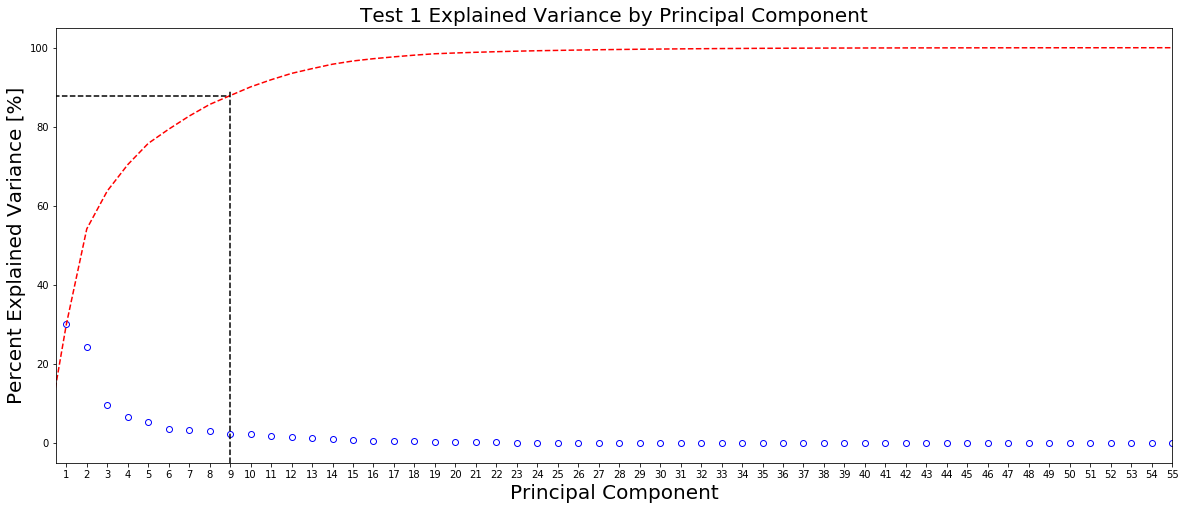

In [9]:
#standardize data before PCA
X = StandardScaler().fit_transform(stats_filt.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X)
pDf_1 = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
pDf_1['Decade']  = stats_filt['Decade'].tolist()
pDf_1['Pos'] = stats_filt['Pos'].tolist()

percent_explained_var = 100*pca.explained_variance_/sum(pca.explained_variance_)
cut_off = 10
cumulative = 0
cumulative_exp = [0]
required_modes = 0
first_time = True
for i in range(0, len(percent_explained_var)):
    cumulative = cumulative + percent_explained_var[i]
    cumulative_exp.append(cumulative)
    if cumulative > (100 - cut_off) and first_time:
        required_modes = i
        first_time = False
        

f, ax1 = plt.subplots(1, 1, figsize=(20, 8))
ax1.plot(np.arange(0,10,1), cumulative_exp[required_modes]*np.ones(10), 'k--')
ax1.plot(np.arange(1,len(pca.explained_variance_) + 1,1).astype(int), percent_explained_var, 'bo', fillStyle='none')
ax1.plot(np.arange(0,len(pca.explained_variance_) + 1,1).astype(int), cumulative_exp, 'r--')
ax1.axvline(x=required_modes, ymin=0, ymax=cumulative_exp[required_modes-1]/100., c='k', ls = '--')
ax1.set_xticks(np.arange(0,len(pca.explained_variance_) + 1,1)) 
ax1.set_title('Test 1 Explained Variance by Principal Component')
ax1.set_ylabel('Percent Explained Variance [%]')
ax1.set_xlabel('Principal Component')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax1.title.set_size(20)
ax1.set_xlim([0.5, 55])

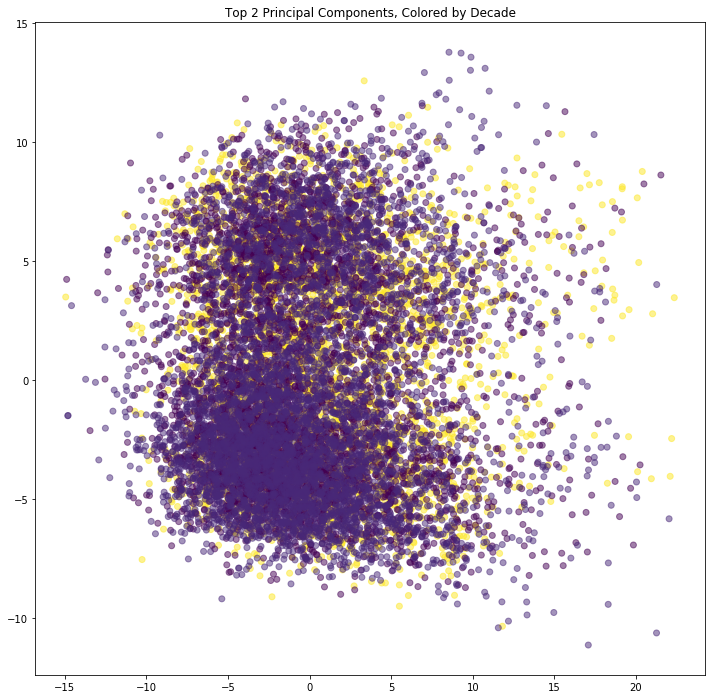

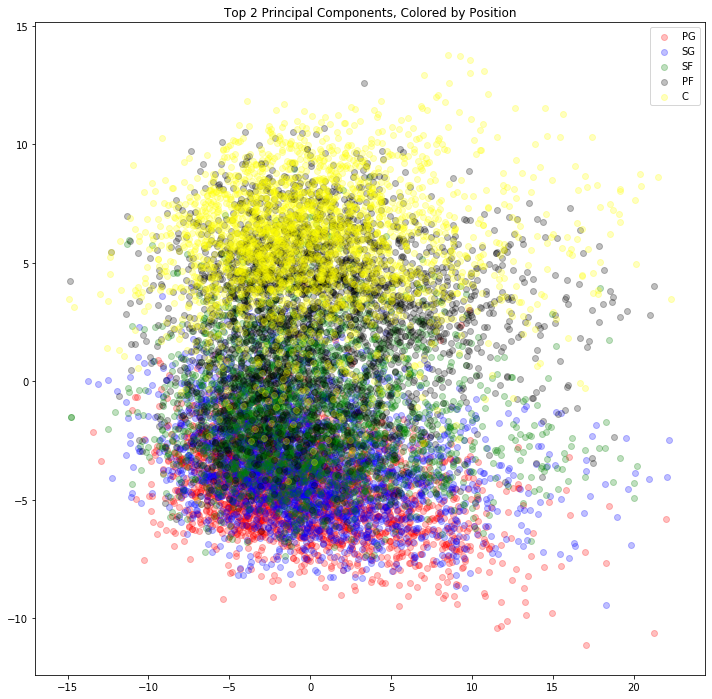

In [7]:
#Top Mode PCA Plots
#first plot colored by decade
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(pDf_1.loc[:,"PC1"], pDf_1.loc[:,"PC2"], alpha=0.5, c=pDf_1.loc[:,'Decade'])
ax.set_title("Top 2 Principal Components, Colored by Decade")

#second plot of principal components colored by position
fig, ax = plt.subplots(figsize=(12, 12))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'black', 'C':'yellow'}
labels = list(colors.keys())
for g in labels:
    ix = pDf_1.index[pDf_1['Pos'] == g]
    ax.scatter(pDf_1.loc[ix, "PC1"], pDf_1.loc[ix, "PC2"], alpha=0.25, c = colors[g], label = g)
ax.set_title("Top 2 Principal Components, Colored by Position")
ax.legend()
#ax.scatter(pDf_1.loc[:,"PC1"], pDf_1.loc[:,"PC2"], alpha=0.5, label=labels ,c=pDf_1.loc[:,'Pos'].apply(lambda x: colors[x]))
ax.legend(labels)




In [21]:
#Splitting the data matrix into three decades
d1 = 3885;  # number of samples from 1990-1999
d2 = 4385; # number of samples from 2000-2009
d3 = 4806; # number of samples 2010-2019
stats_d1 = stats_filt[0:d1]
stats_d2 = stats_filt[d1:d1+d2]
stats_d3 = stats_filt[d1+d2:d1+d2+d3]




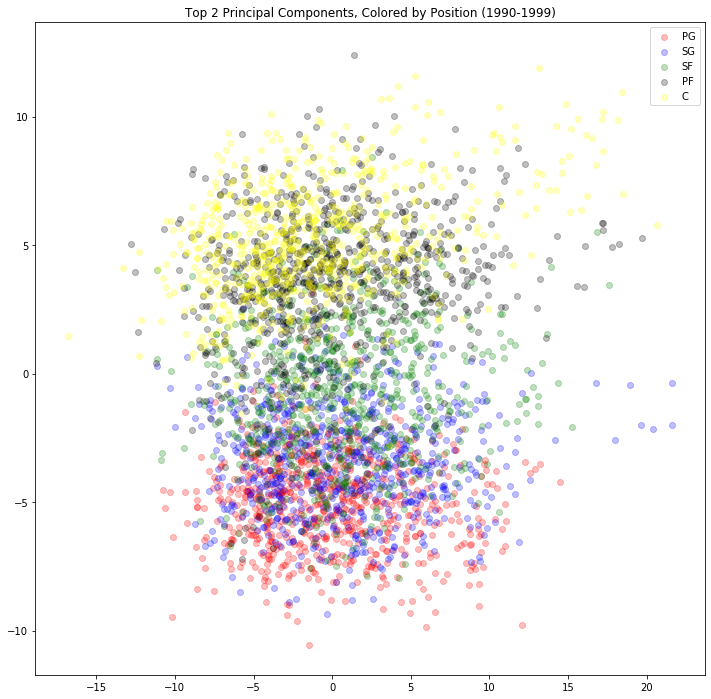

In [9]:
X_1 = StandardScaler().fit_transform(stats_d1.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_1)
pDf_11 = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
pDf_11['Decade']  = stats_d1['Decade'].tolist()
pDf_11['Pos'] = stats_d1['Pos'].tolist()



#plot of principal components colored by position
fig, ax = plt.subplots(figsize=(12, 12))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'black', 'C':'yellow'}
labels = list(colors.keys())
for g in labels:
    ix = pDf_11.index[pDf_11['Pos'] == g]
    ax.scatter(pDf_11.loc[ix, "PC1"], pDf_11.loc[ix, "PC2"], alpha=0.25, c = colors[g], label = g)
ax.set_title("Top 2 Principal Components, Colored by Position (1990-1999)")
ax.legend()
ax.legend(labels)



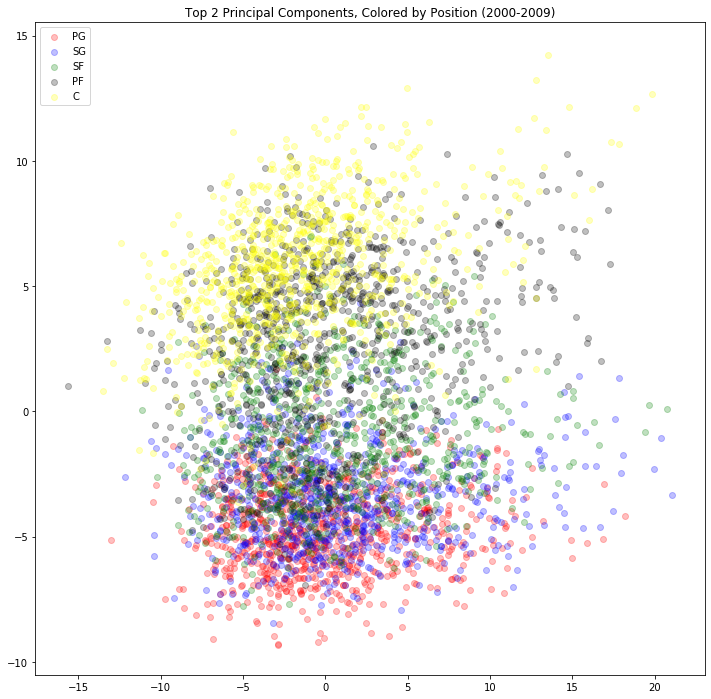

In [10]:
# 2000-2009

X_2 = StandardScaler().fit_transform(stats_d2.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_2)
pDf_12 = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
pDf_12['Decade']  = stats_d2['Decade'].tolist()
pDf_12['Pos'] = stats_d2['Pos'].tolist()


#plot of principal components colored by position
fig, ax = plt.subplots(figsize=(12, 12))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'black', 'C':'yellow'}
labels = list(colors.keys())
for g in labels:
    ix = pDf_12.index[pDf_12['Pos'] == g]
    ax.scatter(pDf_12.loc[ix, "PC1"], pDf_12.loc[ix, "PC2"], alpha=0.25, c = colors[g], label = g)
ax.set_title("Top 2 Principal Components, Colored by Position (2000-2009)")
ax.legend()
ax.legend(labels)

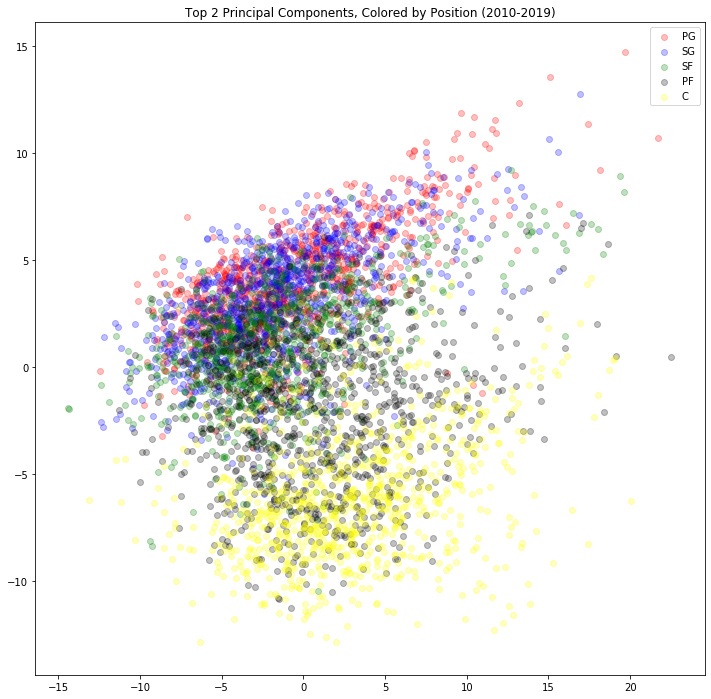

In [11]:
# 2010-2019

X_3 = StandardScaler().fit_transform(stats_d3.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_3)
pDf_13 = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
pDf_13['Decade']  = stats_d3['Decade'].tolist()
pDf_13['Pos'] = stats_d3['Pos'].tolist()


#plot of principal components colored by position
fig, ax = plt.subplots(figsize=(12, 12))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'black', 'C':'yellow'}
labels = list(colors.keys())
for g in labels:
    ix = pDf_13.index[pDf_13['Pos'] == g]
    ax.scatter(pDf_13.loc[ix, "PC1"], pDf_13.loc[ix, "PC2"], alpha=0.25, c = colors[g], label = g)
ax.set_title("Top 2 Principal Components, Colored by Position (2010-2019)")
ax.legend()
ax.legend(labels)

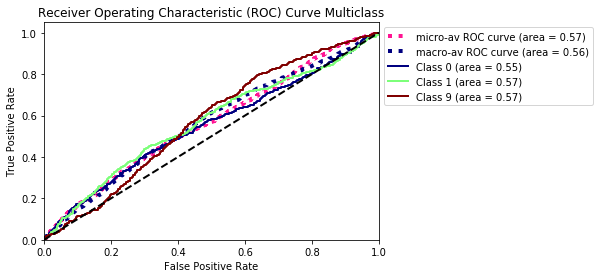

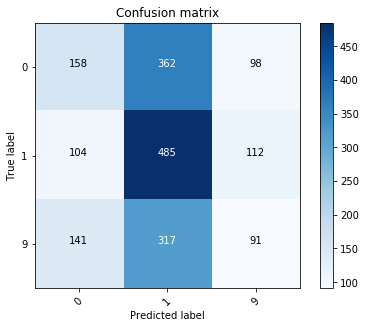

Average accuracy: 38.5786243359106


Text(0.5, 1.0, 'Plot of Accuracy')

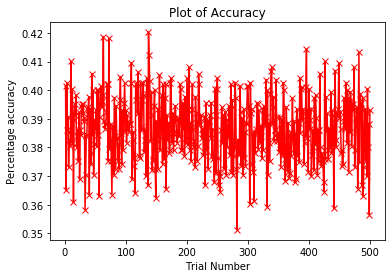

In [47]:
# Linear discrimination analysis by decade 

# standardize data before PCA
X_d= StandardScaler().fit_transform(stats_filt.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_d)

#Using first two components to do LDA


X_dp= principalComponents[:,:2]
labels = stats_filt.loc[:,'Decade']
rs = random.seed(15)#set random seed
classes, y = np.unique(labels, return_inverse=True)#get unique class names and translate to integer values

accuracy = [];

for i in range(1,501):
    #test_size: what proportion of original data is used for test set
    Xtrain, Xtest, ytrain, ytest = train_test_split( X_dp, y, test_size=1/7.0, random_state=rs)
    clf = LDA(n_components = 1,tol=0.01)
    #function returns multiclass ROC plot with AUC scores per class
    clf.fit(Xtrain, ytrain)
    preds_logr = clf.predict(Xtest)#apply the model
    aScore = accuracy_score(ytest, preds_logr)#get accuracy score
    accuracy.append(aScore)
multiclassROC(Xtrain, ytrain, Xtest, ytest, clf, classes)    
CM = confusion_matrix(ytest, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
avg_accuracy = sum(accuracy)/501
print('Average accuracy:', avg_accuracy*100)
x = np.linspace(1,500, 500)
plt.plot(x, accuracy, 'rx-')
plt.xlabel('Trial Number')
plt.ylabel('Percentage accuracy')
plt.title('Plot of Accuracy')


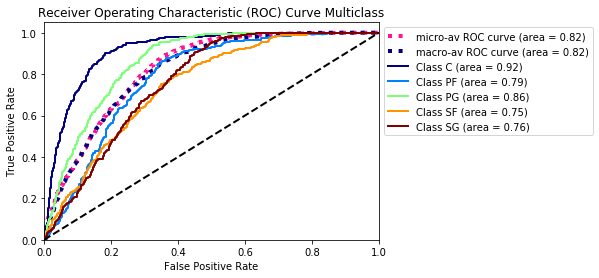

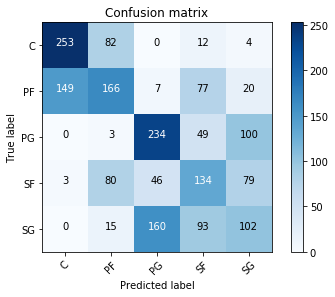

Average accuracy: 48.631003517590024


Text(0.5, 1.0, 'Plot of Accuracy')

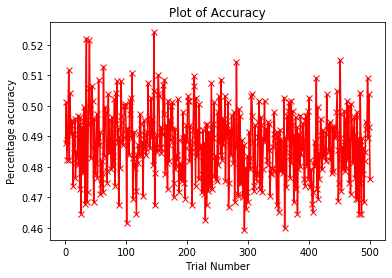

In [48]:
# Linear discrimination analysis by position


# standardize data before PCA
X_p= StandardScaler().fit_transform(stats_filt.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_p)

#Using first two components to do LDA


X_pca= principalComponents[:,:2]
labels = stats_filt.loc[:,'Pos']
rs = random.seed(15)#set random seed

# creating labels 
classes, y = np.unique(labels, return_inverse=True)#get unique class names and translate to integer values

accuracy = []; 
for i in range(1,501):
    #test_size: what proportion of original data is used for test set
    Xtrain, Xtest, ytrain, ytest = train_test_split( X_pca, y, test_size=1/7.0, random_state=rs)
    clf = LDA(n_components = 1,tol=0.01)
    clf.fit(Xtrain, ytrain)
    preds_logr = clf.predict(Xtest)#apply the model
    aScore = accuracy_score(ytest, preds_logr)#get accuracy score
    accuracy.append(aScore)

multiclassROC(Xtrain, ytrain, Xtest, ytest, clf, classes) 
CM = confusion_matrix(ytest, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
avg_accuracy = sum(accuracy)/501
print('Average accuracy:', avg_accuracy*100)
x = np.linspace(1,500, 500)
plt.plot(x, accuracy, 'rx-')
plt.xlabel('Trial Number')
plt.ylabel('Percentage accuracy')
plt.title('Plot of Accuracy')

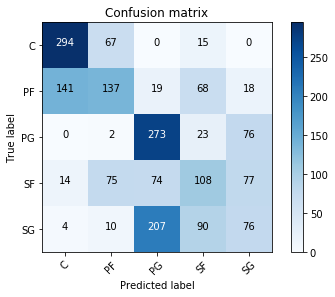

Average accuracy: 47.99490953852467


Text(0.5, 1.0, 'Plot of Accuracy')

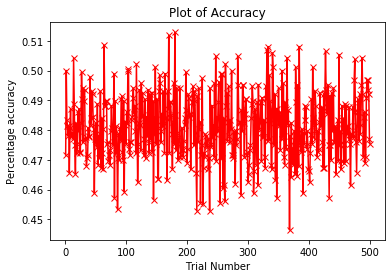

In [46]:
# Using Naive Bayes

# standardize data before PCA
X_d= StandardScaler().fit_transform(stats_filt.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_d)

#Using first two components to do LDA


X_dp= principalComponents[:,:2]
labels = stats_filt.loc[:,'Pos']
rs = random.seed(15)#set random seed
classes, y = np.unique(labels, return_inverse=True)#get unique class names and translate to integer values

accuracy = [];

for i in range(1,501):
    #test_size: what proportion of original data is used for test set
    X_train, X_test, y_train, y_test = train_test_split( X_dp, y, test_size=1/7.0, random_state=rs)
    gnb = GNB()
    #function returns multiclass ROC plot with AUC scores per class
    preds_logr = gnb.fit(X_train, y_train).predict(X_test)#apply the model
    aScore = accuracy_score(y_test, preds_logr)#get accuracy score
    accuracy.append(aScore)
    
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
avg_accuracy = sum(accuracy)/501
print('Average accuracy:', avg_accuracy*100)
x = np.linspace(1,500, 500)
plt.plot(x, accuracy, 'rx-')
plt.xlabel('Trial Number')
plt.ylabel('Percentage accuracy')
plt.title('Plot of Accuracy')

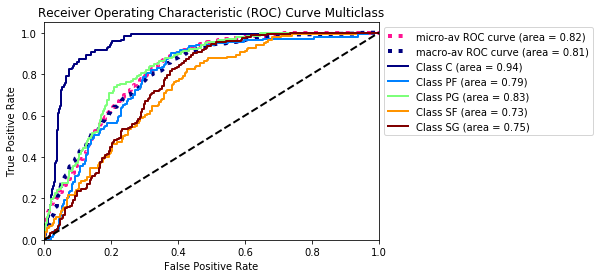

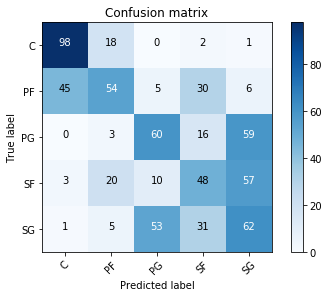

Average accuracy: 48.23685961410515


Text(0.5, 1.0, 'Plot of Accuracy')

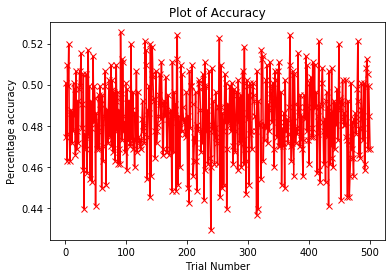

In [22]:

# standardize data before PCA
X_p3= StandardScaler().fit_transform(stats_d3.loc[:, 'MP_pg':])
#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X_p3)

#Using first two components to do LDA


X_pca3= principalComponents[:,:2]
labels = stats_d3.loc[:,'Pos']
rs = random.seed(15)#set random seed

# creating labels 
classes, y = np.unique(labels, return_inverse=True)#get unique class names and translate to integer values

accuracy = []; 
for i in range(1,501):
    #test_size: what proportion of original data is used for test set
    Xtrain, Xtest, ytrain, ytest = train_test_split( X_pca3, y, test_size=1/7.0, random_state=rs)
    clf = LDA(n_components = 1,tol=0.01)
    clf.fit(Xtrain, ytrain)
    preds_logr = clf.predict(Xtest)#apply the model
    aScore = accuracy_score(ytest, preds_logr)#get accuracy score
    accuracy.append(aScore)


multiclassROC(Xtrain, ytrain, Xtest, ytest, clf, classes) 
CM = confusion_matrix(ytest, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
avg_accuracy = sum(accuracy)/501
print('Average accuracy:', avg_accuracy*100)
x = np.linspace(1,500, 500)
plt.plot(x, accuracy, 'rx-')
plt.xlabel('Trial Number')
plt.ylabel('Percentage accuracy')
plt.title('Plot of Accuracy')